# Feature Extraction & Engineering

In [1]:
# import libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from textblob import TextBlob
import textstat
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from nltk.util import bigrams
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Faryad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Faryad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Faryad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Feature Extraction: Text Length, Sentiment Polarity, and Product Name Mention

In [2]:
# Read the dataset
final_df = pd.read_csv("final_dataset.csv")

# Calculate the length of reviews by counting the words in each review and store it as a new feature
final_df['TEXT_LENGTH'] = final_df['REVIEW_TEXT'].apply(lambda x: len(x.split()))

# Analyze sentiment scores (polarity) of each review using TextBlob and store it as a new feature
final_df['SENTIMENT_POLARITY'] = final_df['REVIEW_TEXT'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Define a function to identify if product names are mentioned in review text using bigram matching
def product_title_mention_in_review(row):
    product_title = str(row['PRODUCT_TITLE'])  
    review_text = str(row['REVIEW_TEXT']) 
    
    # Tokenize the product title and review text to words and create bigrams
    product_title_tokens = word_tokenize(product_title.lower())
    review_text_tokens = word_tokenize(review_text.lower())
    product_title_bigrams = set(bigrams(product_title_tokens))
    review_text_bigrams = set(bigrams(review_text_tokens))
    
    # Check if any bigram from the product title is present in the review text and return 'Y' or 'N'
    return 'Y' if any(bigram in review_text_bigrams for bigram in product_title_bigrams) else 'N'

# Apply the function to each row to check for product name mentions in reviews and store the result as a new feature in the dataset
final_df['PRODUCT_NAME_MENTION'] = final_df.apply(product_title_mention_in_review, axis=1)

# Remove the PRODUCT_TITLE column from the dataset as it's no longer needed after extracting the necessary feature
final_df.drop(['PRODUCT_TITLE'], axis=1, inplace=True)

### Feature Importance Visualization

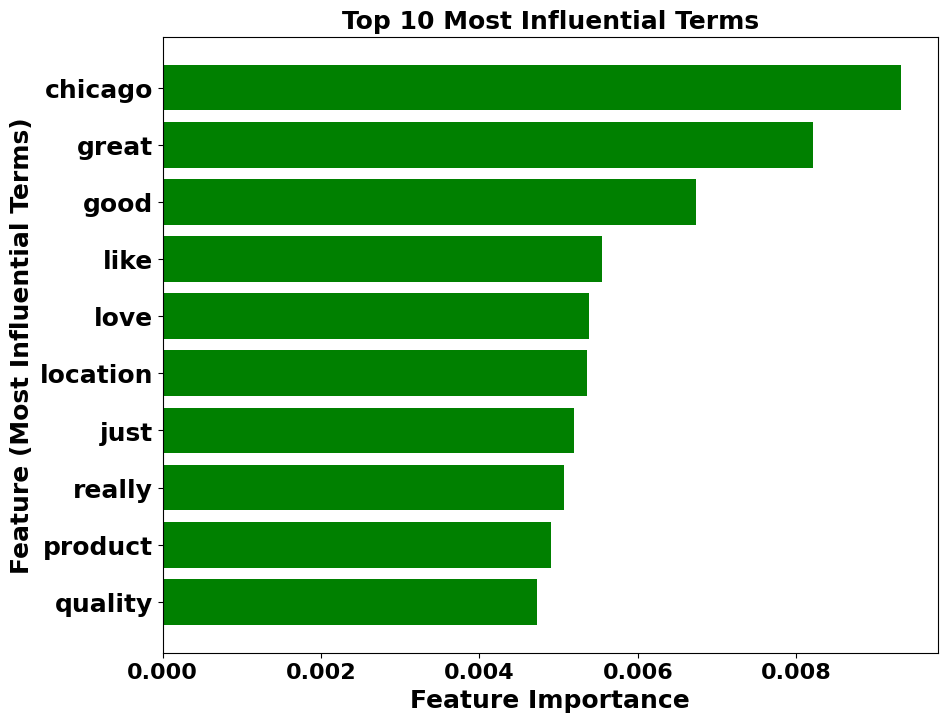

In [8]:
# Splitting the dataset into training and testing sets to prepare for model training and evaluation
X_train, X_test, y_train, y_test = train_test_split(
    final_df['REVIEW_TEXT'], final_df['LABEL'], test_size=0.2, random_state=42)

# Defining a pipeline that includes text preprocessing with CountVectorizer and classification with RandomForest
pipeline = Pipeline([
    # Transform texts to feature vectors, removing English stop words, limiting to top 1000 features
    ('vect', CountVectorizer(stop_words='english', max_features=1000)),  
    ('clf', RandomForestClassifier(random_state=42))  
])

# Training the model on the training data
pipeline.fit(X_train, y_train)

# Extracting feature names and their corresponding importance scores from the RandomForest classifier
feature_names = pipeline.named_steps['vect'].get_feature_names_out()
importances = pipeline.named_steps['clf'].feature_importances_

# Sorting the indices of importances in descending order for better visibility of top features
sorted_indices = np.argsort(importances)[::-1]
top_n_indices = sorted_indices[:10]  # Selecting top 10 features

# Plotting function to display the top 10 most important features
def plot_feature_importances_text(feature_names, importances, n_features=10):
    top_feature_names = feature_names[top_n_indices]  # Getting names of top features
    top_importances = importances[top_n_indices]  # Getting importance scores of top features

    plt.figure(figsize=(10, 8))
    plt.barh(range(n_features), top_importances, align='center', color='green')
    plt.yticks(np.arange(n_features), top_feature_names, fontsize=18, weight='bold')
    plt.xticks(fontsize=16, weight='bold')
    plt.gca().invert_yaxis()  # Inverting the y-axis to show the most important feature at the top
    plt.xlabel("Feature Importance", fontsize=18, weight='bold') 
    plt.ylabel("Feature (Most Influential Terms)", fontsize=18, weight='bold')  
    plt.title("Top 10 Most Influential Terms", fontsize=18, weight='bold')  
    plt.show()

# Calling the plotting function to visualize the feature importances
plot_feature_importances_text(feature_names, importances)

### Feature Engineering: Important Words and Repeating Words Ratio

In [3]:
# Define a list of important words chosen from the top 10 identified through feature importance analysis
important_words = ["great", "love", "like", "really", "quality", "good"]

def add_combined_important_words_count(df, words):
    # Adds a new column to the dataframe that counts the total occurrences of specified important words in each review
    df['IMPORTANT_WORDS_COUNT'] = df['REVIEW_TEXT'].apply(lambda x: sum(x.lower().split().count(word) for word in words))
    return df

# Applying the function to the dataframe 
final_df = add_combined_important_words_count(final_df, important_words)

# Calculate the ratio of repeating words to the total number of words in a text. 
def ratio_repeating_words(text):
    # Tokenizes the text and filters out non-alphanumeric words to focus on significant content only
    words = [word for word in text.split() if word.isalnum()]
    total_word_count = len(words)
    
    # Handle edge cases where text might be too short, returning 0 to avoid division by zero
    if total_word_count <= 1:
        return 0

    # Count occurrences of each word, ignoring case
    word_counts = {}
    for word in words:
        word_lowercase = word.lower()
        if word_lowercase in word_counts:
            word_counts[word_lowercase] += 1
        else:
            word_counts[word_lowercase] = 1

    # Count how many words appear more than once and compute the ratio of such words to the total word count
    repeating_words_count = sum(1 for count in word_counts.values() if count > 1)
    ratio = repeating_words_count / total_word_count  # Ratio of repeating words
    return ratio

# Apply the function to compute the ratio of repeating words for each review in the dataset and store the result as a new feature in the dataset
final_df['RATIO_REPEATING_WORDS'] = final_df['REVIEW_TEXT'].apply(ratio_repeating_words)

### Calculating Additional Text-Based Features

In [4]:
# Calculate the number of stopwords in each review and store it as a new feature
stop = set(stopwords.words('english'))
final_df['STOPWORDS'] = final_df['REVIEW_TEXT'].apply(lambda x: len([word for word in word_tokenize(x.lower()) if word in stop]))

# Compute the Flesch-Kincaid grade level for each review and store it as a new feature
final_df['FK_SCORE'] = final_df['REVIEW_TEXT'].apply(lambda x: textstat.flesch_kincaid_grade(x))

# Count the number of uppercase letters in each review and store it as a new feature
final_df['CAPITALIZATION_COUNT'] = final_df['REVIEW_TEXT'].apply(lambda x: sum(1 for char in x if char.isupper()))

# Count the number of punctuation marks in each review and store it as a new feature
final_df['PUNCTUATION_COUNT'] = final_df['REVIEW_TEXT'].apply(lambda x: sum(1 for char in x if char in string.punctuation))

# Display the updated DataFrame to verify new features
print(final_df.head())

# Save the modified dataset with new features to a CSV file
final_df.to_csv('modified_dataset.csv', index=False)


               PRODUCT_CATEGORY  RATING LABEL  \
0         Sports_and_Outdoors_5     5.0     F   
1                Pet_Supplies_5     5.0     F   
2  Tools_and_Home_Improvement_5     5.0     F   
3              Toys_and_Games_5     4.0     F   
4                       Books_5     5.0     F   

                                         REVIEW_TEXT  SOURCE  \
0  Does what its suppose to, and it's a very comf...  AMAZON   
1  This little vacuum works great.  I have a very...  AMAZON   
2  I have two of these and have had no issues. I ...  AMAZON   
3  I love this thing. It looks real and the mater...  AMAZON   
4  This was purchased for my daughter.  She loves...  AMAZON   

  VERIFIED_PURCHASE REVIEW_TITLE  TEXT_LENGTH  SENTIMENT_POLARITY  \
0               NaN          NaN           18            0.460000   
1               NaN          NaN           55            0.195278   
2               NaN          NaN           93            0.124107   
3               NaN          NaN          15